# Load modules and data

In [362]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
train_data=pd.read_csv("train.csv")
test_data=pd.read_csv("test.csv")
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

In [363]:
print(train_data.head(5))

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  


Straight away I decided to exclude the ticket data as it is in multiply formats and without engineering seems unlikely to be useful. The passenger id data will also be excluded as it has no relation to the other information.

In [364]:
print(train_data.isnull().sum()) 

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


Based partly on this I decided to exclude the cabin data for now as it will require significant engeneering to be useful. 
I decided to clean the age data by replacign the null values with the mean. 

In [365]:
print(train_data.corr()["Survived"])

PassengerId   -0.005007
Survived       1.000000
Pclass        -0.338481
Age           -0.077221
SibSp         -0.035322
Parch          0.081629
Fare           0.257307
Name: Survived, dtype: float64


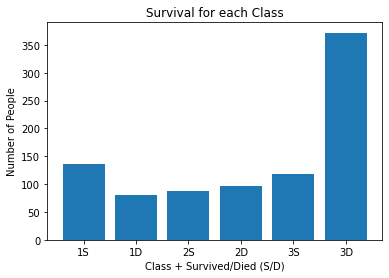

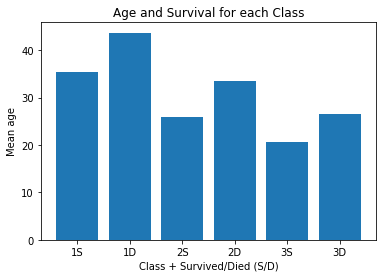

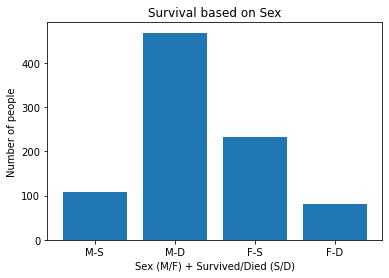

In [366]:
'''train_data.hist(bins=50, figsize=(20,15))
plt.show()'''

first_class=train_data[train_data["Pclass"]==1]
first_class_sur=first_class[first_class['Survived']==1]
first_class_die=first_class[first_class['Survived']==0]

second_class=train_data[train_data["Pclass"]==2]
second_class_sur=second_class[second_class['Survived']==1]
second_class_die=second_class[second_class['Survived']==0]

third_class=train_data[train_data["Pclass"]==3]
third_class_sur=third_class[third_class['Survived']==1]
third_class_die=third_class[third_class['Survived']==0]


labels=['1S','1D','2S','2D','3S','3D']
heights=[len(first_class_sur),len(first_class_die),len(second_class_sur),len(second_class_die),len(third_class_sur),len(third_class_die)]
plt.bar(labels,heights)
plt.title("Survival for each Class")
plt.ylabel('Number of People')
plt.xlabel('Class + Survived/Died (S/D)')
plt.show()


labels=['1S','1D','2S','2D','3S','3D']
heights=[first_class_sur['Age'].mean(),first_class_die['Age'].mean(),second_class_sur['Age'].mean(),second_class_die['Age'].mean(),third_class_sur['Age'].mean(),third_class_die['Age'].mean()]
plt.bar(labels,heights)
plt.title("Age and Survival for each Class")
plt.ylabel('Mean age')
plt.xlabel('Class + Survived/Died (S/D)')
plt.show()

male=train_data[train_data["Sex"]=="male"]
male_sur=male[male["Survived"]==1]
male_die=male[male["Survived"]==0]

female=train_data[train_data["Sex"]=="female"]
female_sur=female[female["Survived"]==1]
female_die=female[female["Survived"]==0]


labels=["M-S","M-D","F-S", "F-D"]
heights=[len(male_sur),len(male_die),len(female_sur),len(female_die),]
plt.bar(labels,heights)
plt.title("Survival based on Sex")
plt.ylabel('Number of people')
plt.xlabel('Sex (M/F) + Survived/Died (S/D)')
plt.show()

Class and Sex have strong relation to survival. It's interestign that once that data is broken into class, age also correlates with survival. 

# Function to check my predictions accuracy on train data

In [367]:
def acc_test(predict_y,real_y):
    errors=0
    for i in range(np.shape(predict_y)[0]):
        if predict_y[i]!=real_y[i]:
            errors+=1
    acc= (np.shape(predict_y)[0]-errors)/(np.shape(predict_y)[0])
    print(acc)

# Clean Data with age mean

In order to create the data set to model in XGBoost, I need to one-hot encode the categorical data. To do this I split the numeric and categorical data, creating a dataframe for each which I later joined.

In [368]:
numeric_train=train_data[["Age","SibSp","Parch","Fare"]].copy()
numeric_train["Age"].fillna(numeric_train["Age"].mean(),inplace=True)
print(numeric_train.head(10))

encoder = OneHotEncoder(handle_unknown='ignore')
encoder.fit(train_data[['Pclass','Sex','Embarked']])
encoder.get_feature_names_out()
cat_train=pd.DataFrame(encoder.transform(train_data[['Pclass','Sex','Embarked']]).toarray())
cat_train.columns = encoder.get_feature_names_out()
#print(cat_train.head(20))

y_train=train_data["Survived"].to_numpy()
x_train=(numeric_train.join(cat_train)).to_numpy()

         Age  SibSp  Parch     Fare
0  22.000000      1      0   7.2500
1  38.000000      1      0  71.2833
2  26.000000      0      0   7.9250
3  35.000000      1      0  53.1000
4  35.000000      0      0   8.0500
5  29.699118      0      0   8.4583
6  54.000000      0      0  51.8625
7   2.000000      3      1  21.0750
8  27.000000      0      2  11.1333
9  14.000000      1      0  30.0708


# The Model

I decided to use the XGBoost model in this project, without tuning it overfit the data so by tuning the parameters I was able to improve my score.

In [369]:
model=XGBClassifier(eta=0.15, max_depth=2, reg_lambda=2) #initially I used default params, these are the result of some tuning
model.fit(x_train,y_train)
y_predict_train=model.predict(x_train)
acc_test(y_predict_train,y_train)

0.8574635241301908


In [370]:
cat_test=pd.DataFrame(encoder.transform(test_data[['Pclass','Sex','Embarked']]).toarray())
cat_test.columns = encoder.get_feature_names_out()

numeric_test=test_data[["Age","SibSp","Parch","Fare"]].copy()
numeric_test["Age"].fillna(numeric_test["Age"].mean(),inplace=True)

x_test=(numeric_test.join(cat_test)).to_numpy()


In [371]:
y_predict2=pd.DataFrame(model.predict(x_test))
test_id=pd.DataFrame(test_data["PassengerId"].copy())


y_submission=test_id.join(y_predict2)
y_submission.columns = ["PassengerId", "Survived"] 


y_submission.to_csv("forth_submission.csv", index=False)


Here is a list of scores:<br><br>
0.74162 untuned (train=0.96520) <br>
0.75837 with max_depth=3 (train=0.91021) <br>
0.76794 with max_depth=2 (train=0.88776)  <br>
0.77511 with max_depth=2 eta=0.2 (train=0.86756) <br>
0.77990 with max_depth=2 eta=0.15 (train=0.85970) <br>
0.77990 with max_depth=2 eta=0.1  (train=0.85185) <br> 
0.77511 with max_depth=2 eta=0.15 reg_lambda=10 (train=0.84511) <br>
0.77990 with max_depth=2 eta=0.15 reg_lambda=2  (train=0.85746) <br><br>
I included train accuracy to show signs of overfit and you can see that initally the accuracy on the train set was very high compared to the test set, indicating overfit. The score starting to plateau then drop indicated that overfitting has been addressed.

# Engineer additional features 

An ideas for additional features that I saw on the competion discussion board was, number of family members. <br> Number of famuily members is pretty straight forward, combining thee SibSp and Parch data will give this. It will be interesting to see if size of a family is more diagnostic than the SibSp and Parch components. <br>


In [372]:
#engineer the title feature
names=train_data["Name"].to_numpy()
for i in range(np.shape(names)[0]):
    names[i]=names[i].split()[1].strip(".")

name_list=[]
for i in range(np.shape(names)[0]):
    if names[i] not in name_list:
        name_list.append(names[i])

name_count=[0]*31
for i in range(np.shape(names)[0]):
    for j in range(len(name_list)):
        if names[i]==name_list[j]:
            name_count[j]+=1

name_features=[]
for j in range(len(name_list)):
    if name_count[j]>10:
        name_features.append(name_list[j])
          

for i in range(np.shape(names)[0]):
    if names[i] not in name_features:
        names[i]="other"
    
#print(names)

In [373]:
#add feature to test data
test_names=test_data["Name"].to_numpy()

for i in range(np.shape(test_names)[0]):
    test_names[i]=test_names[i].split()[1].strip(".")

for i in range(np.shape(test_names)[0]):
    if test_names[i] not in name_features:
        test_names[i]="other"

In [374]:
train_data["Titles"]=pd.DataFrame(names)
print(train_data.head(5))

test_data["Titles"]=pd.DataFrame(test_names) #same for test
print(test_data.head(5))

   PassengerId  Survived  Pclass  Name     Sex   Age  SibSp  Parch  \
0            1         0       3    Mr    male  22.0      1      0   
1            2         1       1   Mrs  female  38.0      1      0   
2            3         1       3  Miss  female  26.0      0      0   
3            4         1       1   Mrs  female  35.0      1      0   
4            5         0       3    Mr    male  35.0      0      0   

             Ticket     Fare Cabin Embarked Titles  
0         A/5 21171   7.2500   NaN        S     Mr  
1          PC 17599  71.2833   C85        C    Mrs  
2  STON/O2. 3101282   7.9250   NaN        S   Miss  
3            113803  53.1000  C123        S    Mrs  
4            373450   8.0500   NaN        S     Mr  
   PassengerId  Pclass Name     Sex   Age  SibSp  Parch   Ticket     Fare  \
0          892       3   Mr    male  34.5      0      0   330911   7.8292   
1          893       3  Mrs  female  47.0      1      0   363272   7.0000   
2          894       2   Mr   

In [375]:
encoder = OneHotEncoder(handle_unknown='ignore')
encoder.fit(train_data[['Pclass','Sex','Embarked','Titles']])
encoder.get_feature_names_out()
cat_train=pd.DataFrame(encoder.transform(train_data[['Pclass','Sex','Embarked','Titles']]).toarray())
cat_train.columns = encoder.get_feature_names_out()

cat_test=pd.DataFrame(encoder.transform(test_data[['Pclass','Sex','Embarked','Titles']]).toarray())
cat_test.columns = encoder.get_feature_names_out()

In [376]:
eng_train=numeric_train.join(cat_train)
eng_train["Family"]=train_data["SibSp"]+train_data["Parch"]
#print(eng_train)
x_train_eng=eng_train.to_numpy()


In [377]:
eng_model=XGBClassifier(eta=0.15, max_depth=2, reg_lambda=2) #initially I used default params, these are the result of some tuning
eng_model.fit(x_train_eng,y_train)
y_predict_train=eng_model.predict(x_train_eng)
acc_test(y_predict_train,y_train)

0.8641975308641975


In [378]:
eng_test=numeric_test.join(cat_test)
eng_test["Family"]=test_data["SibSp"]+test_data["Parch"]
x_test_eng=eng_test.to_numpy()


In [379]:
y_predict_eng=pd.DataFrame(eng_model.predict(x_test_eng))
test_id=pd.DataFrame(test_data["PassengerId"].copy())


y_sub_eng=test_id.join(y_predict_eng)
y_sub_eng.columns = ["PassengerId", "Survived"] 


y_sub_eng.to_csv("Engineered_submission.csv", index=False)

# Scores with the family feature engineered 

New scores <br>
0.76794 (eta=0.15, max_depth=2) (acc=0.85858) <br>
0.77272 (eta=0.15, max_depth=2,lambda=2) (acc=0.86195) <br>
Train data accuracy has stayed the same and score has dropped to overfit has returned <br>
0.77033 (eta=0.1, max_depth=2,reg_lambda=5) (acc=0.84624)<br>
0.77272 (eta=0.15, max_depth=2,lambda=5) (acc=0.85185) <br>
It looks like this is as well as this methoc can fit the data


# Scores with Title feature engineered 

0.77033 (eta=0.15, max_depth=2,reg_lambda=2) (acc=0.86644) <br>
0.77272 (eta=0.15, max_depth=2,reg_lambda=5) (acc=0.85634) <br>
0.77033 (eta=0.15, max_depth=2,reg_lambda=10) (acc=0.85521) <br>
We aren't seeing any better fit here 

# Scores using both engineered features 

0.77990 (eta=0.15, max_depth=2,reg_lambda=2) (acc=0.86195) <br>
0.77990 (eta=0.15, max_depth=2,reg_lambda=5) (acc=0.86083)<br>
Interstingly the combination of these feature is a slight improvement over them individually but this is peaking around the unengineered score.

